# Notebook 05: Inequality and Society

## Does inequality damage health and social outcomes?

Wilkinson & Pickett's *The Spirit Level* (2009) argued that more unequal
rich countries have worse outcomes on a wide range of health and social
indicators: life expectancy, infant mortality, obesity, mental illness,
trust, homicide, imprisonment, and social mobility.

### The debate

**Wilkinson & Pickett (2009):** The relationship is causal, operating through
psychosocial stress. High inequality increases status anxiety, erodes social
cohesion, and damages health through chronic stress pathways.

**Deaton (2003) critique:** The cross-country correlation may reflect the
concavity of the income-health relationship (diminishing marginal returns
to income), not a direct effect of inequality itself.

**Snowdon (2010) critique:** Cherry-picking of countries and indicators.
Including different countries or using different indicators weakens or
eliminates the correlations.

**Greener (2025) update:** Replicating the Spirit Level with 2019 data
shows the relationship has weakened considerably for several outcomes.

### Four proposed causal pathways
1. **Psychosocial stress**: Status anxiety → chronic stress → health damage
2. **Material deprivation**: Fewer resources at the bottom → worse outcomes
3. **Political economy**: Inequality → less investment in public goods
4. **Social capital erosion**: Inequality → less trust → weaker institutions

In [1]:
import sys
sys.path.insert(0, '..')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
from scipy import stats

from data.config import FOCUS_COUNTRIES, COUNTRY_NAMES
from data.plotting import (set_style, country_color, country_name,
                           save_figure, annotate_countries)
from data import health_social, swiid

set_style()

***
## 1. The Spirit Level Scatter: Gini vs. Health/Social Outcomes

Replicating the core claim: more unequal countries have worse outcomes.
We use the SWIID disposable income Gini and World Bank health indicators.

In [2]:
spirit_data = health_social.get_spirit_level_data(year=2019)

if not spirit_data.empty:
    print(f"Countries: {len(spirit_data)}")
    print(f"Columns: {list(spirit_data.columns)}")
    display(spirit_data.head(10))
else:
    print('Spirit Level data not available.')

Countries: 22
Columns: ['country_code', 'gini_disp', 'gini_mkt', 'life_expectancy', 'infant_mortality', 'homicide_rate', 'gdp_per_capita_ppp', 'country_name']


,country_code,gini_disp,gini_mkt,life_expectancy,infant_mortality,homicide_rate,gdp_per_capita_ppp,country_name
0,AT,27.7,49.7,81.895122,2.9,0.867032,60354.927942,Austria
1,AU,32.6,48.1,82.900000,3.2,0.882951,52885.831382,Australia
2,BE,25.8,49.2,81.995122,3.3,1.080302,56712.469572,Belgium
3,CA,29.8,47.5,82.163659,4.5,1.823575,50498.973106,Canada
4,CH,30.6,43.7,83.904878,3.5,0.536285,73732.235332,Switzerland
5,CZ,24.6,43.5,79.229268,2.4,0.862161,45614.017113,Czech Republic
6,DE,30.0,52.0,81.292683,3.1,0.745579,59270.727650,Germany
7,DK,28.0,49.9,81.451220,3.3,0.859902,60594.966400,Denmark
8,ES,32.5,50.5,83.831707,2.6,0.697795,44042.757577,Spain
9,FI,26.0,49.8,81.982927,1.9,1.466924,52276.111572,Finland


***
## 2. Small Multiples: Gini vs. Individual Outcomes

Each panel shows the relationship between inequality and one outcome variable.
We include a linear regression line and report the R-squared.

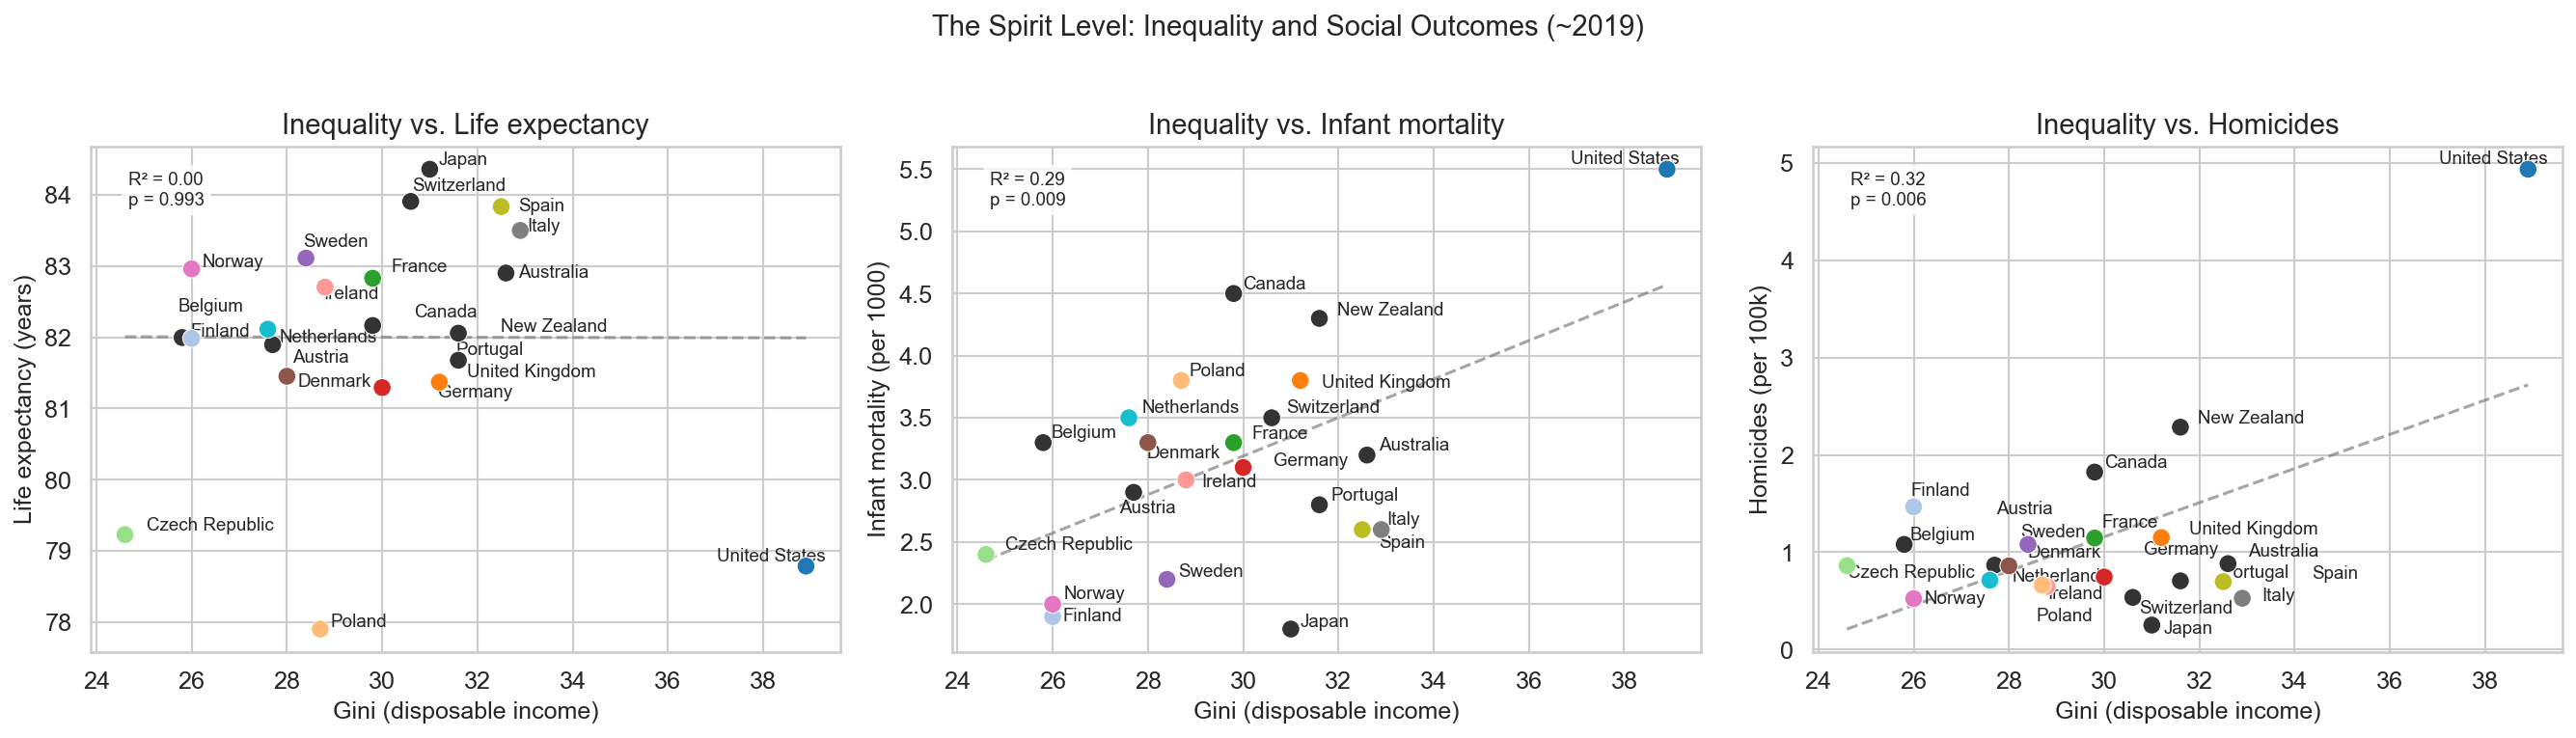

In [3]:
outcome_vars = {
    'life_expectancy': ('Life expectancy (years)', False),
    'infant_mortality': ('Infant mortality (per 1000)', True),
    'homicide_rate': ('Homicides (per 100k)', True),
}

if not spirit_data.empty and 'gini_disp' in spirit_data.columns:
    available = {k: v for k, v in outcome_vars.items() if k in spirit_data.columns}
    n_plots = len(available)

    if n_plots > 0:
        fig, axes = plt.subplots(1, n_plots, figsize=(6 * n_plots, 5))
        if n_plots == 1:
            axes = [axes]

        for ax, (var, (label, higher_is_worse)) in zip(axes, available.items()):
            plot_df = spirit_data.dropna(subset=['gini_disp', var])
            if plot_df.empty:
                continue

            colors = [country_color(c) if c in COUNTRY_NAMES else '#999'
                      for c in plot_df['country_code']]
            ax.scatter(plot_df['gini_disp'], plot_df[var],
                       c=colors, s=80, zorder=5, edgecolors='white', linewidth=0.5)

            # Regression line
            x = plot_df['gini_disp'].values
            y = plot_df[var].values
            mask = np.isfinite(x) & np.isfinite(y)
            if mask.sum() > 3:
                slope, intercept, r, p, se = stats.linregress(x[mask], y[mask])
                x_line = np.linspace(x[mask].min(), x[mask].max(), 100)
                ax.plot(x_line, intercept + slope * x_line,
                        color='gray', linestyle='--', alpha=0.7)
                ax.text(0.05, 0.95, f'R\u00b2 = {r**2:.2f}\np = {p:.3f}',
                        transform=ax.transAxes, fontsize=9, va='top',
                        bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

            annotate_countries(ax, plot_df['gini_disp'].values,
                               plot_df[var].values,
                               plot_df['country_code'].values)

            ax.set_xlabel('Gini (disposable income)')
            ax.set_ylabel(label)
            direction = 'worse \u2192' if higher_is_worse else '\u2190 better'
            ax.set_title(f'Inequality vs. {label.split("(")[0].strip()}')

        fig.suptitle('The Spirit Level: Inequality and Social Outcomes (~2019)',
                     fontsize=14, y=1.02)
        plt.tight_layout()
        save_figure(fig, '05_spirit_level_small_multiples')
        plt.show()
    else:
        print('No outcome variables available in the data.')
else:
    print('Spirit Level data or Gini column not available.')

***
## 3. Sensitivity Test: Remove the US

The US is an extreme outlier on both axes: high inequality AND poor outcomes.
A critical question is whether the correlation survives removing the US.
If a single data point drives the relationship, causal claims are weak.

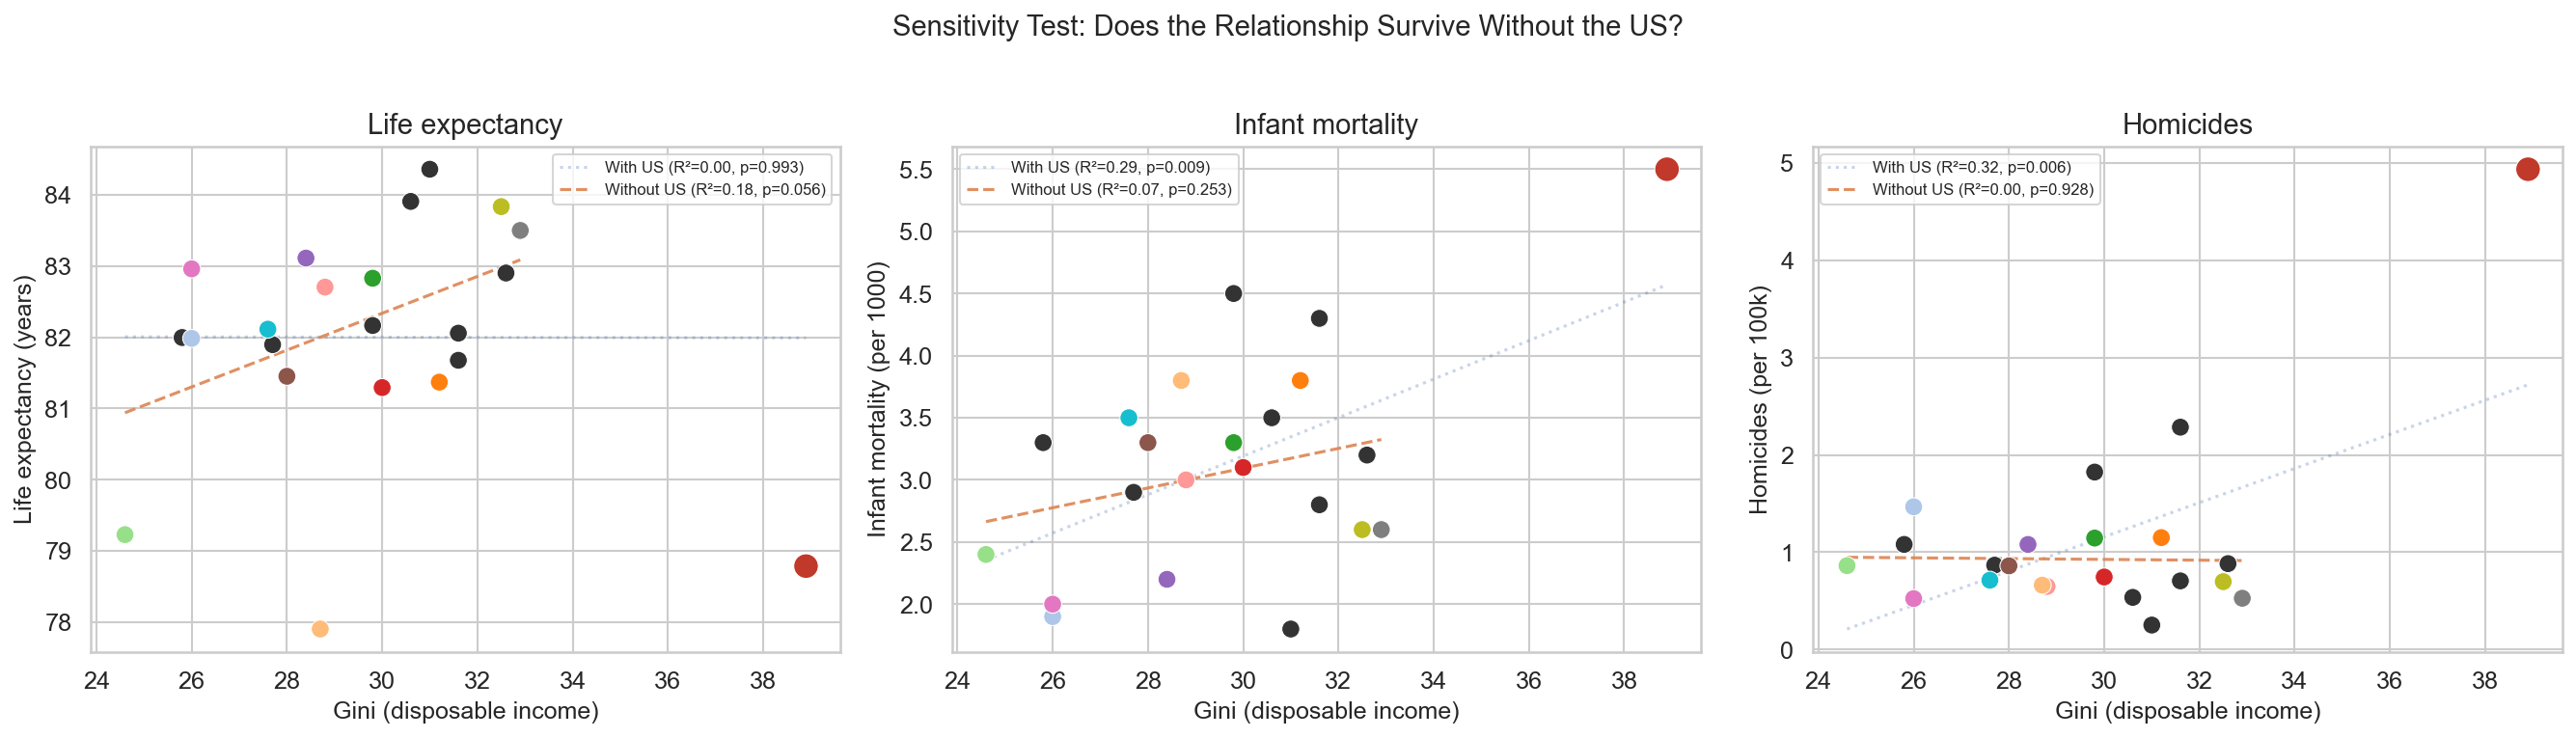

In [4]:
if not spirit_data.empty and 'gini_disp' in spirit_data.columns:
    available = {k: v for k, v in outcome_vars.items() if k in spirit_data.columns}
    n_plots = len(available)

    if n_plots > 0:
        fig, axes = plt.subplots(1, n_plots, figsize=(6 * n_plots, 5))
        if n_plots == 1:
            axes = [axes]

        for ax, (var, (label, _)) in zip(axes, available.items()):
            for include_us, style in [(True, {'alpha': 0.3, 'ls': ':'}),
                                       (False, {'alpha': 0.9, 'ls': '--'})]:
                if include_us:
                    plot_df = spirit_data.dropna(subset=['gini_disp', var])
                    lbl = 'With US'
                else:
                    plot_df = spirit_data[spirit_data['country_code'] != 'US'].dropna(
                        subset=['gini_disp', var])
                    lbl = 'Without US'

                x = plot_df['gini_disp'].values
                y = plot_df[var].values
                mask = np.isfinite(x) & np.isfinite(y)

                if mask.sum() > 3:
                    slope, intercept, r, p, se = stats.linregress(x[mask], y[mask])
                    x_line = np.linspace(x[mask].min(), x[mask].max(), 100)
                    ax.plot(x_line, intercept + slope * x_line,
                            label=f'{lbl} (R\u00b2={r**2:.2f}, p={p:.3f})',
                            **style)

            # Plot points (all countries)
            full_df = spirit_data.dropna(subset=['gini_disp', var])
            colors = ['#c0392b' if c == 'US' else
                      (country_color(c) if c in COUNTRY_NAMES else '#999')
                      for c in full_df['country_code']]
            sizes = [150 if c == 'US' else 80 for c in full_df['country_code']]
            ax.scatter(full_df['gini_disp'], full_df[var],
                       c=colors, s=sizes, zorder=5, edgecolors='white', linewidth=0.5)

            ax.set_xlabel('Gini (disposable income)')
            ax.set_ylabel(label)
            ax.set_title(f'{label.split("(")[0].strip()}')
            ax.legend(fontsize=8)

        fig.suptitle('Sensitivity Test: Does the Relationship Survive Without the US?',
                     fontsize=14, y=1.02)
        plt.tight_layout()
        save_figure(fig, '05_sensitivity_remove_us')
        plt.show()

***
## 4. Controlling for GDP per Capita

Deaton's critique: the correlation between inequality and health may simply
reflect that poorer countries are both more unequal and less healthy. If we
control for GDP per capita, does the inequality effect survive?

In [5]:
if (not spirit_data.empty and 'gini_disp' in spirit_data.columns
        and 'gdp_per_capita_ppp' in spirit_data.columns):

    for var, (label, _) in outcome_vars.items():
        if var not in spirit_data.columns:
            continue

        df = spirit_data.dropna(subset=['gini_disp', var, 'gdp_per_capita_ppp'])
        if len(df) < 5:
            continue

        # Simple bivariate
        r_bivar = stats.pearsonr(df['gini_disp'], df[var])

        # Partial correlation: residualize both on GDP per capita
        x = df[['gini_disp', 'gdp_per_capita_ppp']].values
        y = df[var].values

        # Residualize Gini on GDP
        slope_g, intercept_g, _, _, _ = stats.linregress(
            df['gdp_per_capita_ppp'], df['gini_disp'])
        gini_resid = df['gini_disp'] - (intercept_g + slope_g * df['gdp_per_capita_ppp'])

        # Residualize outcome on GDP
        slope_o, intercept_o, _, _, _ = stats.linregress(
            df['gdp_per_capita_ppp'], df[var])
        outcome_resid = df[var] - (intercept_o + slope_o * df['gdp_per_capita_ppp'])

        r_partial = stats.pearsonr(gini_resid, outcome_resid)

        print(f"\n{label}:")
        print(f"  Bivariate:  r = {r_bivar[0]:.3f}, p = {r_bivar[1]:.3f}")
        print(f"  Partial (controlling for GDP/capita): r = {r_partial[0]:.3f}, "
              f"p = {r_partial[1]:.3f}")
else:
    print('Data not available for partial correlation analysis.')


Life expectancy (years):
  Bivariate:  r = -0.002, p = 0.993
  Partial (controlling for GDP/capita): r = 0.018, p = 0.935

Infant mortality (per 1000):
  Bivariate:  r = 0.543, p = 0.009
  Partial (controlling for GDP/capita): r = 0.555, p = 0.007

Homicides (per 100k):
  Bivariate:  r = 0.569, p = 0.006
  Partial (controlling for GDP/capita): r = 0.579, p = 0.005


***
## 5. Gini vs. Life Expectancy: Detailed View

Life expectancy is the most commonly cited outcome in the Spirit Level
literature. This plot adds GDP per capita as a bubble size to visualize
the three-way relationship.

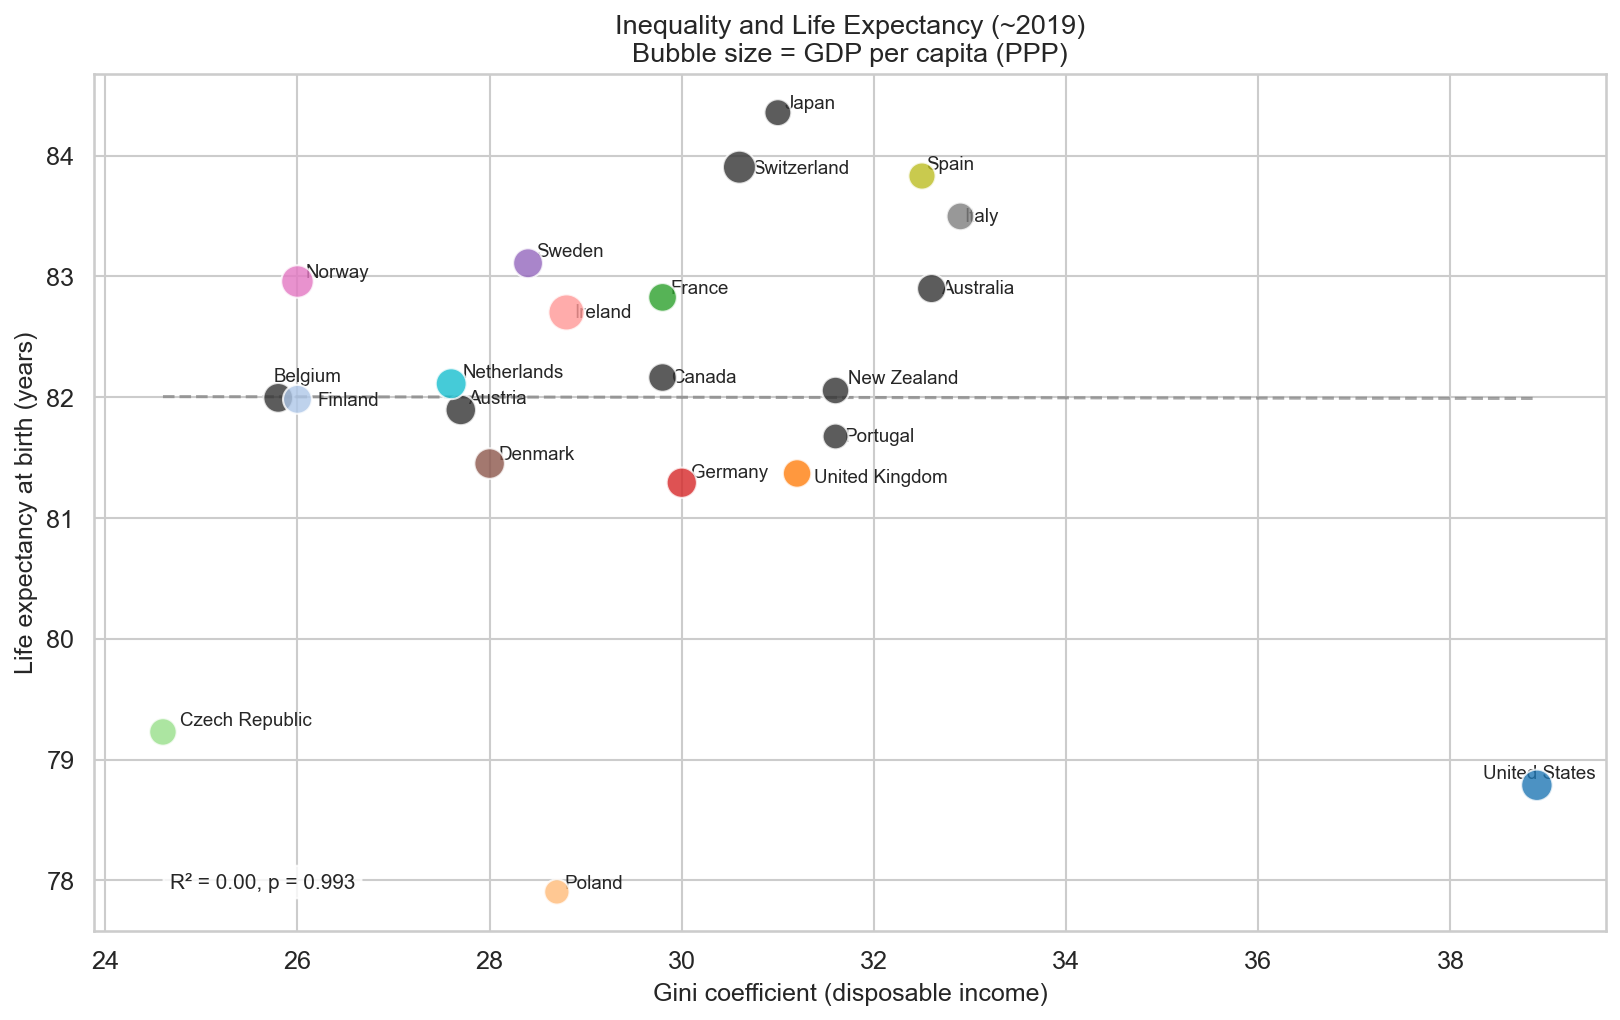

In [6]:
if (not spirit_data.empty and 'gini_disp' in spirit_data.columns
        and 'life_expectancy' in spirit_data.columns
        and 'gdp_per_capita_ppp' in spirit_data.columns):

    df = spirit_data.dropna(subset=['gini_disp', 'life_expectancy', 'gdp_per_capita_ppp'])

    fig, ax = plt.subplots(figsize=(11, 7))

    # Bubble size proportional to GDP per capita
    gdp_norm = df['gdp_per_capita_ppp'] / df['gdp_per_capita_ppp'].max()
    sizes = 50 + 250 * gdp_norm

    colors = [country_color(c) if c in COUNTRY_NAMES else '#999'
              for c in df['country_code']]

    ax.scatter(df['gini_disp'], df['life_expectancy'],
               c=colors, s=sizes, zorder=5, edgecolors='white',
               linewidth=1, alpha=0.8)

    annotate_countries(ax, df['gini_disp'].values,
                       df['life_expectancy'].values,
                       df['country_code'].values)

    # Regression line
    x = df['gini_disp'].values
    y = df['life_expectancy'].values
    mask = np.isfinite(x) & np.isfinite(y)
    if mask.sum() > 3:
        slope, intercept, r, p, se = stats.linregress(x[mask], y[mask])
        x_line = np.linspace(x[mask].min(), x[mask].max(), 100)
        ax.plot(x_line, intercept + slope * x_line,
                color='gray', linestyle='--', alpha=0.7)
        ax.text(0.05, 0.05, f'R\u00b2 = {r**2:.2f}, p = {p:.3f}',
                transform=ax.transAxes, fontsize=10,
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

    ax.set_xlabel('Gini coefficient (disposable income)')
    ax.set_ylabel('Life expectancy at birth (years)')
    ax.set_title('Inequality and Life Expectancy (~2019)\n'
                 'Bubble size = GDP per capita (PPP)', fontsize=13)
    plt.tight_layout()
    save_figure(fig, '05_gini_vs_life_expectancy')
    plt.show()
else:
    print('Data not available for life expectancy plot.')

***
## 6. Changes Over Time: Has the Relationship Held Up?

Greener (2025) found that replicating the Spirit Level with updated data
shows weakening correlations for several outcomes. We compare the
inequality-health relationship at two time points.

Gini-outcome correlations: 2005 vs 2019

Life expectancy (years):
  2005: r = -0.021, R² = 0.000, p = 0.928 (n=22)
  2019: r = -0.002, R² = 0.000, p = 0.993 (n=22)

Infant mortality (per 1000):
  2005: r = 0.643, R² = 0.414, p = 0.001*** (n=22)
  2019: r = 0.543, R² = 0.295, p = 0.009*** (n=22)

Homicides (per 100k):
  2005: r = 0.486, R² = 0.237, p = 0.022** (n=22)
  2019: r = 0.569, R² = 0.323, p = 0.006*** (n=22)


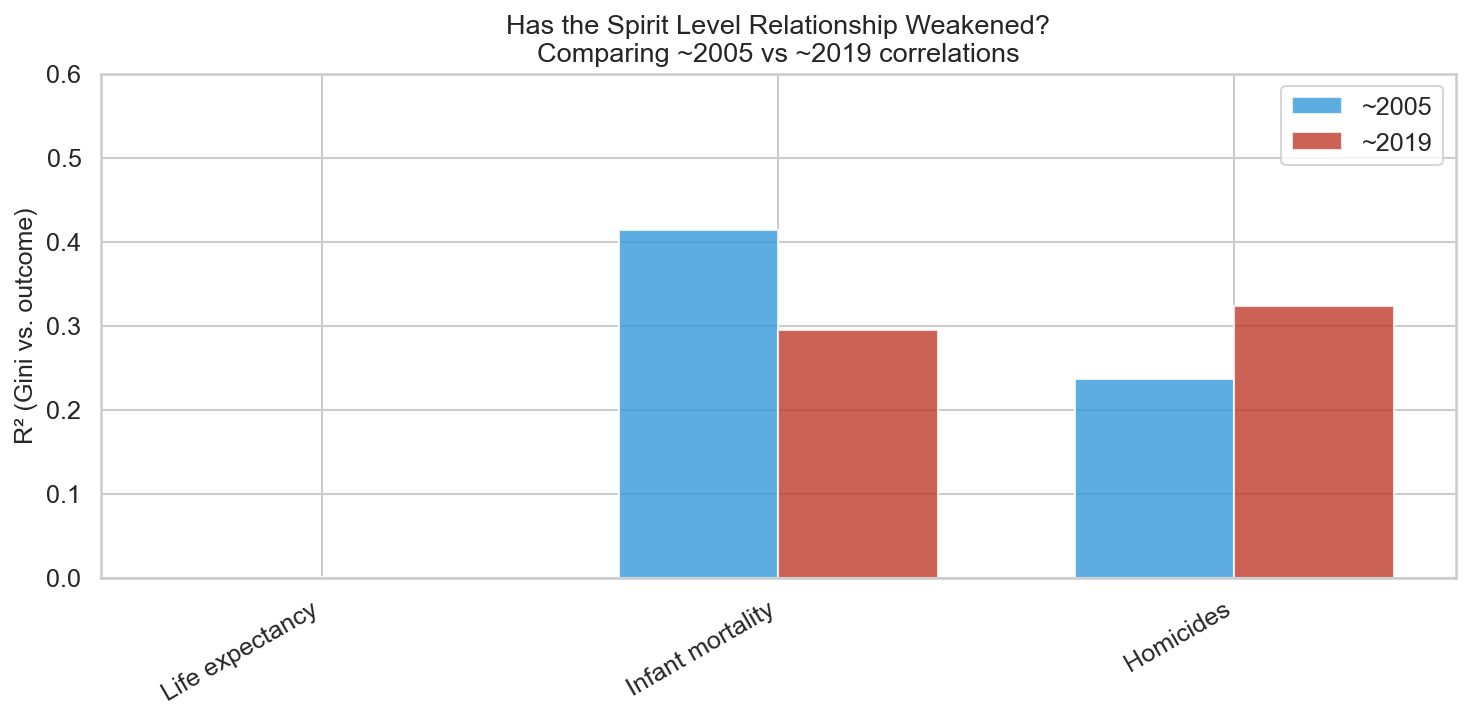

In [7]:
years_to_compare = [2005, 2019]
results = []

for yr in years_to_compare:
    data = health_social.get_spirit_level_data(year=yr)
    if not data.empty and 'gini_disp' in data.columns:
        for var, (label, _) in outcome_vars.items():
            if var in data.columns:
                df = data.dropna(subset=['gini_disp', var])
                if len(df) >= 5:
                    r, p = stats.pearsonr(df['gini_disp'], df[var])
                    results.append({
                        'year': yr, 'outcome': label,
                        'r': r, 'r_squared': r**2, 'p_value': p,
                        'n_countries': len(df),
                    })

if results:
    results_df = pd.DataFrame(results)

    # Display comparison table
    print('Gini-outcome correlations: 2005 vs 2019')
    print('=' * 70)
    for outcome in results_df['outcome'].unique():
        subset = results_df[results_df['outcome'] == outcome]
        print(f"\n{outcome}:")
        for _, row in subset.iterrows():
            sig = '***' if row['p_value'] < 0.01 else ('**' if row['p_value'] < 0.05
                   else ('*' if row['p_value'] < 0.1 else ''))
            print(f"  {row['year']}: r = {row['r']:.3f}, R\u00b2 = {row['r_squared']:.3f}, "
                  f"p = {row['p_value']:.3f}{sig} (n={row['n_countries']})")

    # Bar chart comparing R-squared values
    outcomes_with_both = [o for o in results_df['outcome'].unique()
                          if len(results_df[results_df['outcome'] == o]) == 2]

    if outcomes_with_both:
        fig, ax = plt.subplots(figsize=(10, 5))
        x = np.arange(len(outcomes_with_both))
        width = 0.35

        for i, yr in enumerate(years_to_compare):
            r2_vals = [results_df[(results_df['outcome'] == o) &
                                  (results_df['year'] == yr)]['r_squared'].values[0]
                       for o in outcomes_with_both]
            color = '#3498db' if yr == 2005 else '#c0392b'
            ax.bar(x + i * width, r2_vals, width,
                   label=f'~{yr}', color=color, alpha=0.8)

        short_labels = [o.split('(')[0].strip() for o in outcomes_with_both]
        ax.set_xticks(x + width / 2)
        ax.set_xticklabels(short_labels, rotation=30, ha='right')
        ax.set_ylabel('R\u00b2 (Gini vs. outcome)')
        ax.set_title('Has the Spirit Level Relationship Weakened?\n'
                     'Comparing ~2005 vs ~2019 correlations', fontsize=13)
        ax.legend()
        ax.set_ylim(0, 0.6)
        plt.tight_layout()
        save_figure(fig, '05_spirit_level_over_time')
        plt.show()
else:
    print('Not enough data to compare across time periods.')

***
## 7. Inequality and GDP: Is There a Trade-off?

A common argument against redistribution is that it reduces economic growth.
The cross-sectional evidence does not support a simple equality-prosperity
trade-off among rich countries.

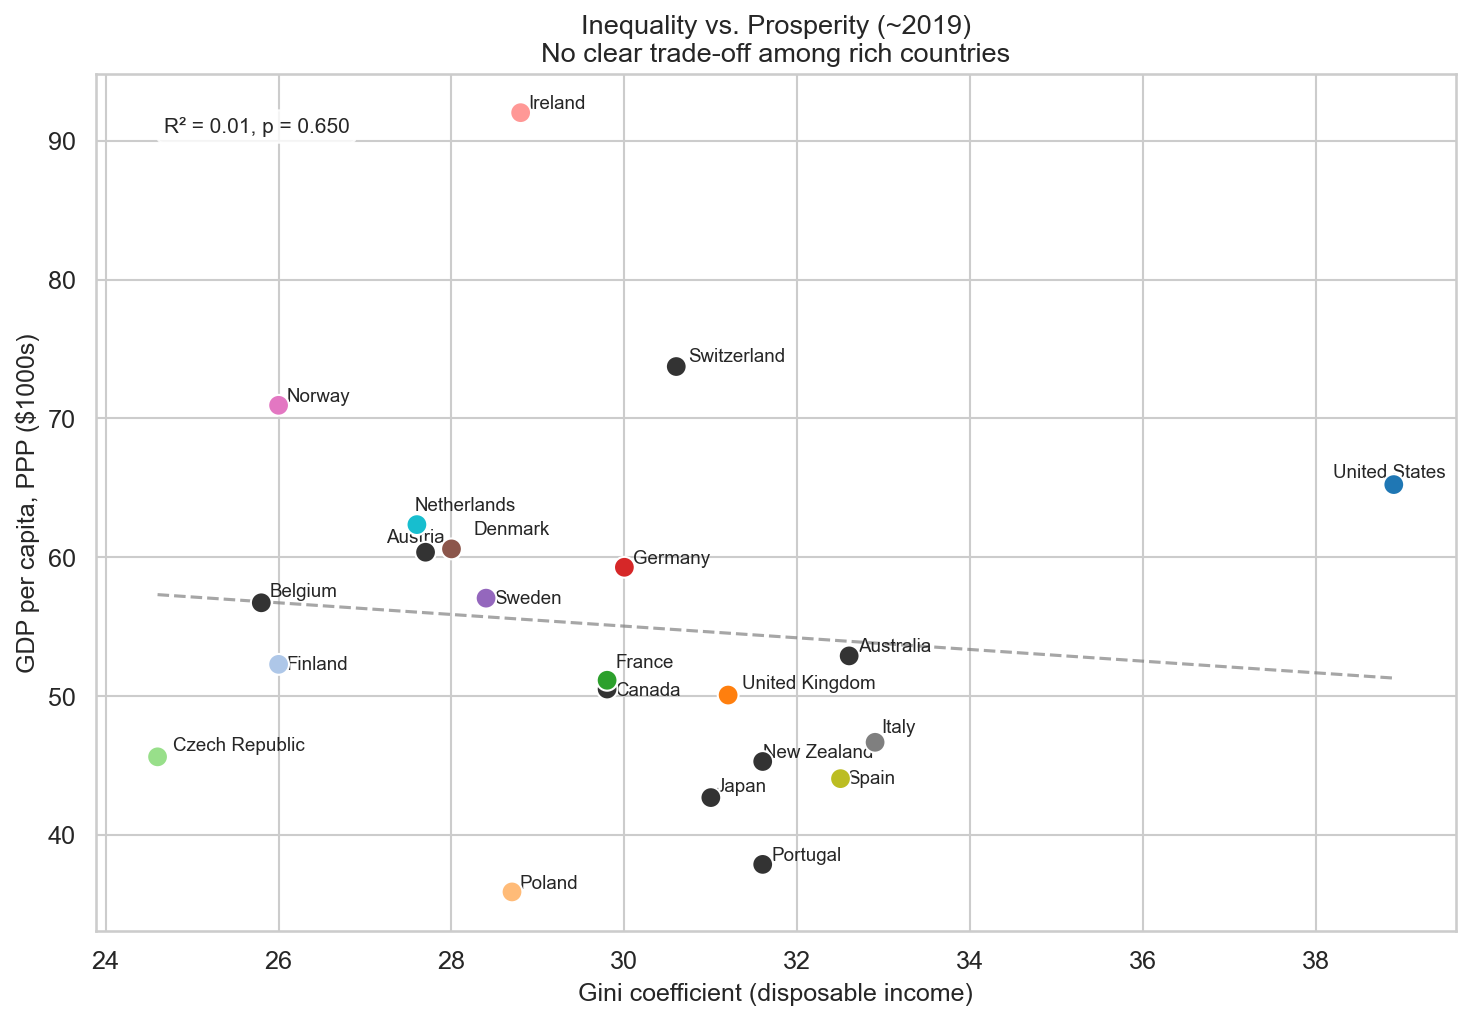

In [8]:
if (not spirit_data.empty and 'gini_disp' in spirit_data.columns
        and 'gdp_per_capita_ppp' in spirit_data.columns):

    df = spirit_data.dropna(subset=['gini_disp', 'gdp_per_capita_ppp'])

    fig, ax = plt.subplots(figsize=(10, 7))
    colors = [country_color(c) if c in COUNTRY_NAMES else '#999'
              for c in df['country_code']]

    ax.scatter(df['gini_disp'], df['gdp_per_capita_ppp'] / 1000,
               c=colors, s=100, zorder=5, edgecolors='white', linewidth=1)

    annotate_countries(ax, df['gini_disp'].values,
                       (df['gdp_per_capita_ppp'] / 1000).values,
                       df['country_code'].values)

    x = df['gini_disp'].values
    y = (df['gdp_per_capita_ppp'] / 1000).values
    mask = np.isfinite(x) & np.isfinite(y)
    if mask.sum() > 3:
        slope, intercept, r, p, se = stats.linregress(x[mask], y[mask])
        x_line = np.linspace(x[mask].min(), x[mask].max(), 100)
        ax.plot(x_line, intercept + slope * x_line,
                color='gray', linestyle='--', alpha=0.7)
        ax.text(0.05, 0.95, f'R\u00b2 = {r**2:.2f}, p = {p:.3f}',
                transform=ax.transAxes, fontsize=10, va='top',
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

    ax.set_xlabel('Gini coefficient (disposable income)')
    ax.set_ylabel('GDP per capita, PPP ($1000s)')
    ax.set_title('Inequality vs. Prosperity (~2019)\n'
                 'No clear trade-off among rich countries', fontsize=13)
    plt.tight_layout()
    save_figure(fig, '05_gini_vs_gdp')
    plt.show()
else:
    print('Data not available for GDP scatter.')

***
## Key Takeaways

1. **The Spirit Level correlations are real but fragile.** More unequal rich
   countries do tend to have worse health and social outcomes, but the
   relationships are sensitive to country selection and time period.

2. **The US is a massive outlier.** Removing the US weakens many of the
   correlations considerably, raising questions about generalizability.

3. **Controlling for GDP matters.** Some correlations weaken when controlling
   for national income, consistent with Deaton's alternative explanation.

4. **The relationship may be weakening.** Greener (2025) finds that updated
   data shows weaker correlations for several outcomes, possibly because
   health improvements in some unequal countries have outpaced inequality growth.

5. **There is no equality-prosperity trade-off.** Cross-sectional evidence
   does not support the claim that less inequality means less prosperity.
   Nordic countries achieve both.

6. **Causation remains debated.** The four proposed pathways (psychosocial
   stress, material deprivation, political economy, social capital) are all
   plausible but difficult to disentangle empirically.